# Random Forest MLB MVP Predictor
### CSDS 133
### Jakye Amos, Sean Donahue, Jeremy Bullis

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

Importing the batting data CSV file and reducing it down to show the data from only the desired timeframe (1960-2022)

In [2]:
stats = pd.read_csv('Batting.csv')
stats["yearID"] = stats["yearID"].astype(int)
stats = stats[stats['yearID'] > 1960]
stats

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
41262,aaronha01,1961,1,ML1,NL,155,603,115,197,39,...,120.0,21.0,9.0,56,64.0,20.0,2.0,1.0,9.0,16.0
41263,adairje01,1961,1,BAL,AL,133,386,41,102,21,...,37.0,5.0,2.0,35,51.0,4.0,2.0,1.0,4.0,6.0
41264,adcocjo01,1961,1,ML1,NL,152,562,77,160,20,...,108.0,2.0,1.0,59,94.0,4.0,2.0,4.0,2.0,22.0
41265,aguirha01,1961,1,DET,AL,45,9,0,0,0,...,1.0,0.0,0.0,0,8.0,0.0,0.0,3.0,1.0,0.0
41266,allenbo04,1961,1,CLE,AL,48,12,0,2,1,...,0.0,0.0,0.0,0,5.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112179,zimmebr01,2022,1,TOR,AL,77,76,11,8,4,...,3.0,2.0,1.0,5,33.0,0.0,5.0,1.0,0.0,0.0
112180,zimmebr01,2022,2,PHI,NL,9,16,4,4,1,...,0.0,0.0,0.0,0,4.0,0.0,0.0,0.0,0.0,0.0
112181,zimmebr01,2022,3,TOR,AL,23,13,3,1,0,...,2.0,1.0,1.0,0,8.0,0.0,1.0,0.0,0.0,0.0
112182,zimmebr02,2022,1,BAL,AL,15,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


The current columns in the batting dataframe. Some will need to be removed and some will need to be added.

In [3]:
print(stats.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')


Importing the awards dataframe and isolating only players nominated for the MVP award during the desired timeframe

In [4]:
awards = pd.read_csv('AwardsSharePlayers.csv')
awards['yearID'] = awards['yearID'].astype(int)
awards = awards[awards['awardID'] == 'MVP']
awards = awards[awards['yearID'] > 1960]
awards

,awardID,yearID,lgID,playerID,pointsWon,pointsMax,votesFirst
2951,MVP,1961,AL,aparilu01,16.0,280,0.0
2952,MVP,1961,AL,arroylu01,95.0,280,1.0
2953,MVP,1961,AL,barbest01,7.0,280,0.0
2954,MVP,1961,AL,berrayo01,2.0,280,0.0
2955,MVP,1961,AL,cashno01,151.0,280,1.0
...,...,...,...,...,...,...,...
6838,MVP,2016,NL,braunry02,2.0,420,0.0
6839,MVP,2016,NL,hendrky01,2.0,420,0.0
6840,MVP,2016,NL,molinya01,2.0,420,0.0
6841,MVP,2016,NL,blackch02,1.0,420,0.0


The batting and awards dataframe are merged about each player's name and year so that every player's batting stats will be matched to their MVP points for every year they were nominated.

In [5]:
merged = pd.merge(stats, awards, on=['yearID','playerID'])

The merged graph

In [6]:
merged

,playerID,yearID,stint,teamID,lgID_x,G,AB,R,H,2B,...,IBB,HBP,SH,SF,GIDP,awardID,lgID_y,pointsWon,pointsMax,votesFirst
0,aaronha01,1961,1,ML1,NL,155,603,115,197,39,...,20.0,2.0,1.0,9.0,16.0,MVP,NL,39.0,224,0.0
1,altmage01,1961,1,CHN,NL,138,518,77,157,28,...,3.0,4.0,4.0,7.0,4.0,MVP,NL,9.0,224,0.0
2,aparilu01,1961,1,CHA,AL,156,625,90,170,24,...,0.0,1.0,4.0,4.0,12.0,MVP,AL,16.0,280,0.0
3,arroylu01,1961,1,NYA,AL,65,25,2,7,2,...,0.0,0.0,3.0,0.0,0.0,MVP,AL,95.0,280,1.0
4,barbest01,1961,1,BAL,AL,37,80,6,13,1,...,0.0,1.0,9.0,0.0,0.0,MVP,AL,7.0,280,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3032,troutmi01,2016,1,LAA,AL,159,549,123,173,32,...,12.0,11.0,0.0,5.0,5.0,MVP,AL,356.0,420,19.0
3033,turneju01,2016,1,LAN,NL,151,556,79,153,34,...,1.0,10.0,0.0,8.0,16.0,MVP,NL,44.0,420,0.0
3034,verlaju01,2016,1,DET,AL,34,5,1,1,0,...,0.0,0.0,0.0,0.0,0.0,MVP,AL,2.0,420,0.0
3035,vottojo01,2016,1,CIN,NL,158,556,101,181,34,...,15.0,5.0,0.0,8.0,16.0,MVP,NL,100.0,420,0.0


There are a number of stats that must be added to the dataframe: slugging percentage (SLG), on-base percentage (OBP), batting average (AVG), and on-base plus slugging (OPS). Plate appearances (PA) must also be calculated as it is used in the calculation of on-base percentage. To control for different numbers of at-bats between players affecting overall season totals, all statistics are divided by the number of at-bats. Walks (BB) are divided by plate appearances as walks don't count as at-bats but do count as plate appearances. A new column is also added to store the proportion of the maximum possible points a player has won. This is done because the maximum number of points has changed through the years, meaning there are point totals that could have won MVP in 1961 but not in 2022. The points proportion will be what the random forest is trained to predict.

In [7]:
## plate appearances are the total of at-bats, walks, hits-by-pitch, and sacrifice flies
merged['PA'] = merged['AB'] + merged['BB'] + merged['HBP'] + merged['SF']
## pointsProp stores the proportion of the maximum number of points that the player scored
merged['pointsProp'] = merged['pointsWon'] / merged['pointsMax']
## slugging percentage is equal to the total number of bases a player gets per at-bat
merged['SLG'] = ((merged['H'] - merged['2B'] - merged['3B'] - merged['HR']) + 2*merged['2B'] + 3*merged['3B'] + 4*merged['HR']) / merged['AB']
## on-base percentage measures how many times a player gets safely on-base per plate appearance
merged['OBP'] = (merged['H'] + merged['BB'] + merged['HBP']) / merged['PA']
## on-base plus slugging is the sum of on-base percentage and slugging percentage
merged['OPS'] = merged['SLG'] + merged['OBP']
## batting average measures the number of hits a player gets per at-bat
merged['AVG'] = merged['H'] / merged['AB']
## all other stats are divided by number of at-bats to control for different players having differing numbers of at-bats
merged['2B'] = merged['2B'] / merged['AB']
merged['3B'] = merged['3B'] / merged['AB']
merged['HR'] = merged['HR'] / merged['AB']
merged['RBI'] = merged['RBI'] / merged['AB']
merged['R'] = merged['R'] / merged['AB']
## walks are divided by plate appearances, as they count as plate appearances but do not count as at-bats
merged['BB'] = merged['BB'] / merged['PA']
merged['SB'] = merged['SB'] / merged['AB']
merged['SO'] = merged['SO'] / merged['AB']


merged

,playerID,yearID,stint,teamID,lgID_x,G,AB,R,H,2B,...,lgID_y,pointsWon,pointsMax,votesFirst,PA,pointsProp,SLG,OBP,OPS,AVG
0,aaronha01,1961,1,ML1,NL,155,603,0.190713,197,0.064677,...,NL,39.0,224,0.0,670.0,0.174107,0.593698,0.380597,0.974295,0.326700
1,altmage01,1961,1,CHN,NL,138,518,0.148649,157,0.054054,...,NL,9.0,224,0.0,569.0,0.040179,0.559846,0.353251,0.913097,0.303089
2,aparilu01,1961,1,CHA,AL,156,625,0.144000,170,0.038400,...,AL,16.0,280,0.0,668.0,0.057143,0.352000,0.312874,0.664874,0.272000
3,arroylu01,1961,1,NYA,AL,65,25,0.080000,7,0.080000,...,AL,95.0,280,1.0,25.0,0.339286,0.360000,0.280000,0.640000,0.280000
4,barbest01,1961,1,BAL,AL,37,80,0.075000,13,0.012500,...,AL,7.0,280,0.0,86.0,0.025000,0.250000,0.220930,0.470930,0.162500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3032,troutmi01,2016,1,LAA,AL,159,549,0.224044,173,0.058288,...,AL,356.0,420,19.0,681.0,0.847619,0.550091,0.440529,0.990620,0.315118
3033,turneju01,2016,1,LAN,NL,151,556,0.142086,153,0.061151,...,NL,44.0,420,0.0,622.0,0.104762,0.492806,0.339228,0.832034,0.275180
3034,verlaju01,2016,1,DET,AL,34,5,0.200000,1,0.000000,...,AL,2.0,420,0.0,5.0,0.004762,0.200000,0.200000,0.400000,0.200000
3035,vottojo01,2016,1,CIN,NL,158,556,0.181655,181,0.061151,...,NL,100.0,420,0.0,677.0,0.238095,0.550360,0.434269,0.984629,0.325540


All unneeded columns are removed from the data frame and added to another dataframe for storage in case they are needed later. These include non-statistical columns such as player name and year. In addition, all MVP information is removed that is not the proportion of the maximum points. Finally, all non-essential player statistics, such as stolen bases (SB), intentional walks (IBB), and hits by pitch (HBP), are removed to ensure as little overfitting as possible. Statistics such as hits (H), doubles (2B), and triples (3B), are also removed as they are already accounted for by batting average and slugging percentage.

In [8]:
extra = merged[['playerID', 'teamID', 'stint', 'lgID_y', 'votesFirst', 'lgID_x', 'awardID',
               'CS', 'IBB', 'HBP', 'SF', 'GIDP', 'pointsMax', 'SH', 'pointsWon', 'yearID', 'pointsProp', 'AB',
               'H', 'G', '3B', '2B', 'PA', 'SB']].copy()
merged = merged.drop(['playerID', 'teamID', 'stint', 'lgID_y', 'votesFirst', 'lgID_x', 'awardID',
               'CS', 'IBB', 'HBP', 'SF', 'GIDP', 'pointsMax', 'SH', 'pointsWon', 
                      'yearID', 'AB', 'H', 'G', '3B', '2B', 'PA', 'SB'], axis=1)
merged = merged.dropna(axis=0)

The final list of variables that will be given to the random forest. Every column will be a feature except for pointsProp, which will become the labels to be predicted.

In [9]:
print(merged.columns)

Index(['R', 'HR', 'RBI', 'BB', 'SO', 'pointsProp', 'SLG', 'OBP', 'OPS', 'AVG'], dtype='object')


The final dataframe containing the information given to the random forest.

In [10]:
merged

,R,HR,RBI,BB,SO,pointsProp,SLG,OBP,OPS,AVG
0,0.190713,0.056385,0.199005,0.083582,0.106136,0.174107,0.593698,0.380597,0.974295,0.326700
1,0.148649,0.052124,0.185328,0.070299,0.177606,0.040179,0.559846,0.353251,0.913097,0.303089
2,0.144000,0.009600,0.072000,0.056886,0.052800,0.057143,0.352000,0.312874,0.664874,0.272000
3,0.080000,0.000000,0.000000,0.000000,0.160000,0.339286,0.360000,0.280000,0.640000,0.280000
4,0.075000,0.025000,0.075000,0.058140,0.525000,0.025000,0.250000,0.220930,0.470930,0.162500
...,...,...,...,...,...,...,...,...,...,...
3032,0.224044,0.052823,0.182149,0.170338,0.249545,0.847619,0.550091,0.440529,0.990620,0.315118
3033,0.142086,0.048561,0.161871,0.077170,0.192446,0.104762,0.492806,0.339228,0.832034,0.275180
3034,0.200000,0.000000,0.000000,0.000000,0.400000,0.004762,0.200000,0.200000,0.400000,0.200000
3035,0.181655,0.052158,0.174460,0.159527,0.215827,0.238095,0.550360,0.434269,0.984629,0.325540


Defining the x and y variables (features and labels)

In [11]:
## labels stores the points proportion, the value that the random forest will try to predict
labels = np.array(merged['pointsProp'])
## pointsProp is now removed from the dataframe so the rest of the columns can become features
merged = merged.drop('pointsProp', axis = 1)
merged_list = list(merged.columns)
## features stores the information that will be used to predict points proportion
features = np.array(merged)

The data is split into training and testing sets. 75% of the data will be used for training, while the remaining 25% will be used for testing.

In [12]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

Our random forest regressor is created, consisting of 1000 decision trees, a number we chose to balance between model accuracy and the time needed to run our model.

In [13]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels);

In [14]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2124, 9)
Training Labels Shape: (2124,)
Testing Features Shape: (708, 9)
Testing Labels Shape: (708,)


A dataframe displaying our predicted points proportions as compared to the actual points proportions. As can be seen from the numbers, the numerical predictions are not extremely accurate, something that is shown again in our accuracy metrics in the next cell.

In [15]:
y_pred = rf.predict(test_features)
df=pd.DataFrame({'Actual':test_labels, 'Predicted':y_pred})
df

,Actual,Predicted
0,1.000000,0.270270
1,0.147619,0.066276
2,0.244898,0.200258
3,0.130102,0.100756
4,0.003571,0.033157
...,...,...
703,0.005952,0.087670
704,0.035714,0.366908
705,0.022959,0.353883
706,0.025510,0.057562


Our accuracy numbers are not stellar, considering our prediction values for points proportion only range from 0 to around 0.5. However, our final rankings present a much different picture.

In [16]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', mean_absolute_error(test_labels, predictions))
print('Mean Squared Error:', mean_squared_error(test_labels, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_labels, predictions)))

Mean Absolute Error: 0.13557739968425678
Mean Squared Error: 0.034999161440435134
Root Mean Squared Error: 0.18708062818056587


A new dataframe that stores the batting statistics of every 2023 player, as our original dataset only contains data through 2022. This dataframe will similarly need to be modified before a prediction can be made. 

In [17]:
newdata = pd.read_csv('mlb-player-stats-Batters.csv')
newdata

,Player,Team,Pos,Age,G,AB,R,H,2B,3B,...,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
0,Marcus Semien,TEX,2B,33,162,670,122,185,40,4,...,3,72,110,0,5,5,0.276,0.348,0.478,0.826
1,Julio Rodriguez,SEA,OF,22,155,654,102,180,37,2,...,10,47,175,0,2,11,0.275,0.333,0.485,0.818
2,Ronald Acuna,ATL,OF,25,159,643,149,217,35,4,...,14,80,84,0,3,9,0.337,0.416,0.596,1.012
3,Bobby Witt,KC,SS,23,158,641,97,177,28,11,...,15,40,121,1,8,4,0.276,0.319,0.495,0.814
4,Trea Turner,PHI,SS,30,155,639,102,170,35,5,...,0,45,150,0,1,6,0.266,0.320,0.459,0.779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,Chandler Seagle,SD,C,27,1,1,0,0,0,0,...,0,0,0,0,0,0,0.000,0.000,0.000,0.000
703,Charlie Culberson,ATL,3B,34,1,1,0,1,0,0,...,0,0,0,0,0,0,1.000,1.000,1.000,2.000
704,Diego Castillo,ARI,OF,26,1,1,0,0,0,0,...,0,0,0,0,0,0,0.000,0.000,0.000,0.000
705,Mason McCoy,TOR,SS,28,6,1,2,0,0,0,...,0,0,1,0,0,0,0.000,0.000,0.000,0.000


In [18]:
print(newdata.columns)

Index(['Player', 'Team', 'Pos', 'Age', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'SB', 'CS', 'BB', 'SO', 'SH', 'SF', 'HBP', 'AVG', 'OBP', 'SLG',
       'OPS'],
      dtype='object')


The statistics are similarly all divided by number of at-bats to control for differing numbers of at-bats between players. Again, walks are divided by plate appearances because walks are counted as plate appearances but not as at-bats.

In [19]:
df2 = newdata
df2['PA'] = df2['AB'] + df2['BB'] + df2['HBP'] + df2['SF']
df2['2B'] = df2['2B'] / df2['AB']
df2['3B'] = df2['3B'] / df2['AB']
df2['HR'] = df2['HR'] / df2['AB']
df2['R'] = df2['R'] / df2['AB']
df2['RBI'] = df2['RBI'] / df2['AB']
df2['BB'] = df2['BB'] / df2['PA']
df2['SO'] = df2['SO'] / df2['AB']


df2 = newdata.drop(['Player', 'Team', 'Pos', 'Age', 'CS', 'SH', 'SF', 'HBP', 'AB', 'G', 
                    'H', '3B', '2B', 'PA', 'SB'], axis=1)

All batters with under 450 at-bats are removed, as stats can be inflated as number of at-bats decreases and because no batter with under 450 will be likely to have made enough of an impact on the sport to be chosen as MVP.

In [20]:
df2 = df2.drop(newdata[newdata['AB'] < 450].index)
df2

,R,HR,RBI,BB,SO,AVG,OBP,SLG,OPS
0,0.182090,0.043284,0.149254,0.095745,0.164179,0.276,0.348,0.478,0.826
1,0.155963,0.048930,0.157492,0.065826,0.267584,0.275,0.333,0.485,0.818
2,0.231726,0.063764,0.164852,0.108844,0.130638,0.337,0.416,0.596,1.012
3,0.151326,0.046802,0.149766,0.057720,0.188768,0.276,0.319,0.495,0.814
4,0.159624,0.040689,0.118936,0.065123,0.234742,0.266,0.320,0.459,0.779
...,...,...,...,...,...,...,...,...,...
122,0.133479,0.039387,0.207877,0.079840,0.210066,0.258,0.317,0.438,0.755
123,0.183807,0.045952,0.157549,0.146520,0.260394,0.293,0.401,0.499,0.900
124,0.109649,0.039474,0.140351,0.061350,0.203947,0.272,0.317,0.441,0.758
125,0.171806,0.037445,0.134361,0.098299,0.240088,0.244,0.338,0.407,0.745


The new dataframe is fed to the random forest and the regressor's predictions are stored in a new dataframe (newpred).

In [21]:
df2 = np.array(df2)
newpred = rf.predict(df2)

The prediction data from newpred is transferred to newpredsorted, where it is sorted based on the predicted points proportions.

In [22]:
newpredsorted = newpred
newpredsorted = sorted(newpredsorted, reverse=True)

The indices of the top 20 players in the now sorted dataframe are now added to an array ind, which is then printed. The numbers printed correspond to each player's index within the newpred dataframe. To access them, we need to search at these indices within newpred.

In [23]:
ind = []
for i in newpredsorted[:20]:
    ind.append(np.where(newpred == i))
    
print(ind)

[(array([2]),), (array([33]),), (array([17]),), (array([32]),), (array([92]),), (array([7]),), (array([47]),), (array([19]),), (array([6]),), (array([91]),), (array([110]),), (array([104]),), (array([0]),), (array([123]),), (array([55]),), (array([48]),), (array([60]),), (array([80]),), (array([50]),), (array([103]),)]


When printing out the players at these indices in newdata, we obtain a list of the top 20 players, regardless of league. To determine the MVPs, we need to separate the players by league and find the top 3 in each league.

In [24]:
print(newdata.iloc[2]['Player'])
print(newdata.iloc[33]['Player'])
print(newdata.iloc[17]['Player'])
print(newdata.iloc[32]['Player'])
print(newdata.iloc[92]['Player'])
print(newdata.iloc[7]['Player'])
print(newdata.iloc[47]['Player'])
print(newdata.iloc[19]['Player'])
print(newdata.iloc[6]['Player'])
print(newdata.iloc[91]['Player'])
print(newdata.iloc[110]['Player'])
print(newdata.iloc[104]['Player'])
print(newdata.iloc[0]['Player'])
print(newdata.iloc[123]['Player'])
print(newdata.iloc[55]['Player'])
print(newdata.iloc[48]['Player'])
print(newdata.iloc[60]['Player'])
print(newdata.iloc[80]['Player'])
print(newdata.iloc[50]['Player'])
print(newdata.iloc[103]['Player'])

Ronald Acuna
Mookie Betts
Matt Olson
Kyle Schwarber
Shohei Ohtani
Austin Riley
Juan Soto
Francisco Lindor
Freddie Freeman
Cody Bellinger
Corey Seager
Max Muncy
Marcus Semien
Bryce Harper
Gunnar Henderson
Pete Alonso
Adolis Garcia
Yandy Diaz
Corbin Carroll
James Outman


The top three players from each league are printed out, with the top player in each league representing the model's predicted MVP for that league. Under each predicted top three is the actual top three ranking. As can be seen from these predictions, the predicted ranks are much more accurate than our accuracy metrics would suggest. For added context, Matt Olson, the player our model predicted to place in 3rd, actually received fourth place while Freddie Freeman, the player who actually received 3rd place, was ranked in 7th by our model.

In [25]:
## an array of the given indices from above
indices = [2, 33, 17, 32, 92, 7, 47, 19, 6, 91, 110, 104, 0, 123, 55, 48, 60, 80, 50, 103]

## two arrays are created to store the players from the American and National Leagues
alplayers = []
nlplayers = []

## Two arrays that store the teams that play in each league
AL = ['OAK', 'SEA', 'LAA', 'HOU', 'TEX', 'MIN', 'DET', 'NYY', 'TB', 'KC', 'CWS', 'BOS', 'BAL', 'CLE', 'TOR']
NL = ['SF', 'LAD', 'SD', 'ARI', 'NYM', 'MIA', 'MIL', 'ATL', 'WSH', 'CIN', 'PHI', 'STL', 'CHC', 'COL', 'PIT']

## Loop that adds players to either alplayers or nlplayers based on which league their team belongs to
for i in indices:
    if newdata.iloc[i]['Team'] in AL:
        alplayers.append(newdata.iloc[i])
    else:
        nlplayers.append(newdata.iloc[i])

## the top three players in each league are printed out, along with lists showing the actual top three
print('National League Predicted MVP Rankings')
for i in range(0,3):
    x = i + 1
    print(str(i + 1) + '. ' + (str)(nlplayers[i]['Player']) + ' - ' + (str)(nlplayers[i]['Team']))

print('\nNational League Actual MVP Rankings')
print('1. Ronald Acuna - ATL\n2. Mookie Betts - LAD\n3. Freddie Freeman - LAD')

print('\n\nAmerican League Predicted MVP Rankings')
for i in range(0,3):
    x = i + 1
    print(str(i + 1) + '. ' + (str)(alplayers[i]['Player']) + ' - ' + (str)(alplayers[i]['Team']))
    
print('\nAmerican League Actual MVP Rankings')
print('1. Shohei Ohtani - LAA\n2. Corey Seager - TEX\n3. Marcus Semien - TEX')

National League Predicted MVP Rankings
1. Ronald Acuna - ATL
2. Mookie Betts - LAD
3. Matt Olson - ATL

National League Actual MVP Rankings
1. Ronald Acuna - ATL
2. Mookie Betts - LAD
3. Freddie Freeman - LAD


American League Predicted MVP Rankings
1. Shohei Ohtani - LAA
2. Corey Seager - TEX
3. Marcus Semien - TEX

American League Actual MVP Rankings
1. Shohei Ohtani - LAA
2. Corey Seager - TEX
3. Marcus Semien - TEX


The next cell produces a graph showing the statistics of the two MVPs vs the average levels produced by the top 20 players overall.

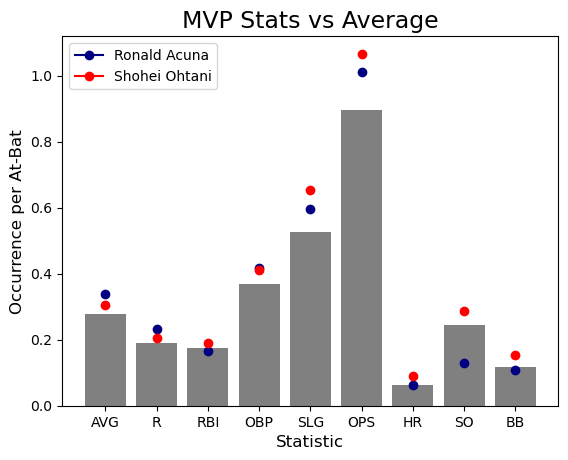

In [26]:
players = []

## the players array stores the players represented by the indices in the indices array
for i in indices:
    players.append(newdata.iloc[i])

df = pd.DataFrame(players)
avg = 0
r = 0
rbi = 0
obp = 0
slg = 0
ops = 0
hr = 0
so = 0
bb = 0

for i in range(0, 20):
    avg += players[i]['AVG']
    r += players[i]['R']
    rbi += players[i]['RBI']
    obp += players[i]['OBP']
    slg += players[i]['SLG']
    ops += players[i]['OPS']
    hr += players[i]['HR']
    so += players[i]['SO']
    bb += players[i]['BB']
    
avg = avg / 20
r = r / 20
rbi = rbi / 20
obp = obp / 20
slg = slg / 20
ops = ops / 20
hr = hr / 20
so = so / 20
bb = bb / 20

## the average values of every stat among the top 20 are compiled into the values array
values = [avg, r, rbi, obp, slg, ops, hr, so, bb]

## the xval array contains the labels for each of the above stats
xval = ['AVG', 'R', 'RBI', 'OBP', 'SLG', 'OPS', 'HR', 'SO', 'BB']

## a bar graph is created with each bar representing the average value for the top 20 players for that statistic
plt.bar(xval, values, color='gray')
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')

## the NL MVP Acuna's stats are added as navy dots
plt.plot('AVG', players[0]['AVG'], marker='o', color='navy', label='Ronald Acuna')
plt.plot('R', players[0]['R'], marker='o', color='navy')
plt.plot('RBI', players[0]['RBI'], marker='o', color='navy')
plt.plot('OBP', players[0]['OBP'], marker='o', color='navy')
plt.plot('SLG', players[0]['SLG'], marker='o', color='navy')
plt.plot('OPS', players[0]['OPS'], marker='o', color='navy')
plt.plot('HR', players[0]['HR'], marker='o', color='navy')
plt.plot('SO', players[0]['SO'], marker='o', color='navy')
plt.plot('BB', players[0]['BB'], marker='o', color='navy')

## the AL MVP Ohtani's stats are added as red dots
plt.plot('AVG', players[4]['AVG'], marker='o', color='red', label='Shohei Ohtani')
plt.plot('R', players[4]['R'], marker='o', color='red')
plt.plot('RBI', players[4]['RBI'], marker='o', color='red')
plt.plot('OBP', players[4]['OBP'], marker='o', color='red')
plt.plot('SLG', players[4]['SLG'], marker='o', color='red')
plt.plot('OPS', players[4]['OPS'], marker='o', color='red')
plt.plot('HR', players[4]['HR'], marker='o', color='red')
plt.plot('SO', players[4]['SO'], marker='o', color='red')
plt.plot('BB', players[4]['BB'], marker='o', color='red')

plt.title('MVP Stats vs Average', fontsize=17)
plt.ylabel('Occurrence per At-Bat', fontsize=12)
plt.xlabel('Statistic', fontsize=12)

plt.legend(loc="upper left")

plt.show()
print()

A graph that shows the relative importance of each statistic used in the prediction. OPS is relatively predictably the most important feature, as it is does a good job of combining and summarizing hitting consistency and hitting power. More surprisingly, home runs and batting average, two of the main statistics people like to look at to determine a good hitter, are relatively low when it comes to their importance in predicting an MVP.

Text(0, 0.5, 'Player Stat')

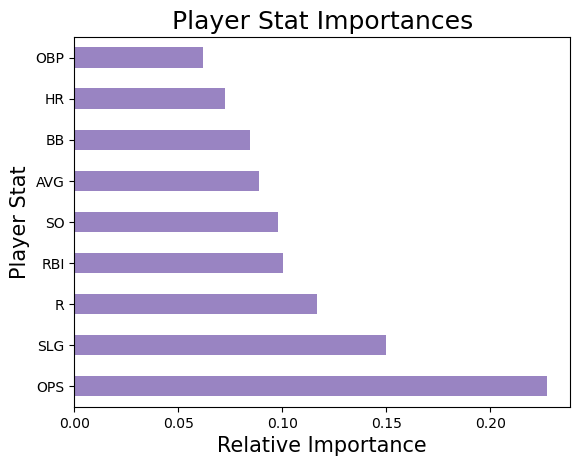

In [27]:
color = (0.5, 
         0.4, 
         0.7,
         0.8
         ) 
feat_importances = pd.Series(rf.feature_importances_, index=merged.columns)
feat_importances.nlargest(len(merged.columns)).plot(kind='barh', color=color)
plt.title("Player Stat Importances", fontsize=18)
plt.xlabel("Relative Importance", fontsize=15)
plt.ylabel("Player Stat", fontsize=15)